<a href="https://colab.research.google.com/github/hillsonghimire/EO-training-resources/blob/main/Topographic_Wetness_Index_(TWI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
#  Title:  Time Series Analysis of Vegetation
#  Author: hillson ghimire
#  Date:   Jan 2024
# ==========================================

# Time series analysis of vegetation



1.   Net Primary Productivity (NPP) trend analysis
2.   Gross Primary Productivity (GPP) trend anslysis
3. NDVI Time-Series Analysis

Dataset:
1. [MOD17A3HGF.061: Terra Net Primary Production Gap-Filled Yearly Global 500m](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD17A3HGF?hl=en)
2. [USGS Landsat 5 Level 2, Collection 2, Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C02_T1_L2?hl=en), Surface Reflectance Data



In [ ]:
# !pip install geemap
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import pandas as pd

import geemap
import ipywidgets as widgets

import ee
ee.Authenticate()

In [ ]:
ee.Initialize(project='gee-ait')

### A. Select AOI

In [ ]:
# Map visualisation parameters
zoom = 8
width="30%"
height="500px"
center = [34.92, 68.85]

# Select Area of Interest (AOI) using 'Draw a Rectangle' tool, the first drawn shape will become AOI
print("Select AOI using 'Draw a Rectangle' tool")
Map = geemap.Map(center = center, zoom = zoom, height=height, width=width)
feature = Map.draw_features
Map

In [ ]:
# extract bounding box polygon

features = []
for element in (Map.draw_control.data):
  new_dict = {key: value for key, value in element.items() if key == 'geometry'}
  # print("new_dict:", new_dict)
  features.append(new_dict)


# area_coord = features[0]['geometry']['coordinates']
area_coord = [[[68.847958, 34.292025], [68.847958, 34.924982], [69.512229, 34.924982], [69.512229, 34.292025], [68.847958, 34.292025]]]

aoi = ee.Geometry.Polygon(area_coord, None, False)
display(aoi)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              68.847958,
              34.292025
            ],
            [
              68.847958,
              34.924982
            ],
            [
              69.512229,
              34.924982
            ],
            [
              69.512229,
              34.292025
            ],
            [
              68.847958,
              34.292025
            ]
          ]
        ]
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

### B. Select ImageCollection from EE catalogue

In [ ]:
# define period of analysis
startDate = "2000-01-01"
endDate = "2024-01-30"
startDate = ee.Date(startDate)
endDate = ee.Date(endDate)

# get MODIS image collection and select NDVI band
# MOD17A3HGF.061: Terra Net Primary Production Gap-Filled Yearly Global 500m
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD17A3HGF
modis = ee.ImageCollection("MODIS/061/MOD17A3HGF").filterDate(startDate, endDate)

In [ ]:
display(modis)

In [ ]:
# Select NPP and GPP using ".select()""
gpp = modis.select('Gpp')
npp = modis.select('Npp')

In [ ]:
display(gpp)          # ImageCollection
display(gpp.first())  # First Image from ImageCollection

In [ ]:
#Visualize GPP
Map = geemap.Map(center = center, zoom = zoom, height=height, width=width)
vis_ParaGPP = {'min':0, 'max':19000, 'palette':['FF0000', 'E7EC77', '4EC96A']}  # palette red:'FF0000', yellow:'E7EC77', green:'4EC96A'
Map.addLayer(gpp.first().clip(aoi), vis_ParaGPP, name="GPP")
Map

### Statistics of an Image Region using "reduceRegion" on image
Image Reducers Overview:

*   aggregate data over time, space, and other data structures.
*   More: https://geohackweek.github.io/GoogleEarthEngine/04-reducers/


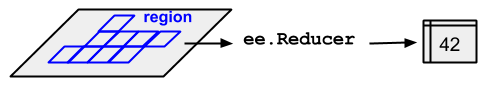

In [ ]:
def reducer(image):
  return image.reduceRegion(ee.Reducer.mean(), geometry=aoi)

# reduceRegion is spatial reducer, that acts over the given geometric area
# Other reducers are: max, min, median, count, histogram, linearfit, stdDev, mode, variance etc. among many

In [ ]:
display(reducer(gpp.first()))

### C. Time-Series GPP


##### C.1 Image Statistics for Gpp ImageCollection

In [ ]:
# Function definition for image reducer
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)
    return ee.Feature(geometry, stat).set({'millis': img.date().millis()}) # ee.Feature(geometry, properties)
  return reduce_region_function

# Define function
reduce_index = create_reduce_region_function(
     geometry=aoi,
     reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:4326')


In [ ]:
# Create FeatureCollection of image statistics with additional "geometry" and "millis" field
# pass input FeatureCollection "gpp" or "npp"
stat_fc = ee.FeatureCollection(gpp.map(reduce_index))

# Display output
display(stat_fc)

##### C.2 Reduce and Structure the data to pandas dataframe

In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()   # retrieves the property names of the first feature (fc.first()) in the FeatureCollection fc. Assumes all features in collection has same properties
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),      # aggregate property values into a list for each property across all features in the collection.
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists) # Construct a dictionary from two parallel lists of keys and values.

In [ ]:
data_dict = fc_to_dict(stat_fc).getInfo() # dictionary
# print(data_dict)
data_df = pd.DataFrame(data_dict)         # data_frame
display(data_df.head())                   # display table

,Gpp,millis,system:index
0,7751.047455,978307200000,2001_01_01
1,7845.214357,1009843200000,2002_01_01
2,7933.672104,1041379200000,2003_01_01
3,7742.535523,1072915200000,2004_01_01
4,7948.862569,1104537600000,2005_01_01


In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

data_df = add_date_info(data_df)
data_df = data_df.drop(columns=['millis', 'system:index'])
display(data_df.head())

,Gpp,Timestamp,Year,Month,Day,DOY
0,7751.047455,2001-01-01,2001,1,1,1
1,7845.214357,2002-01-01,2002,1,1,1
2,7933.672104,2003-01-01,2003,1,1,1
3,7742.535523,2004-01-01,2004,1,1,1
4,7948.862569,2005-01-01,2005,1,1,1


##### C.3 Plot the time series chart

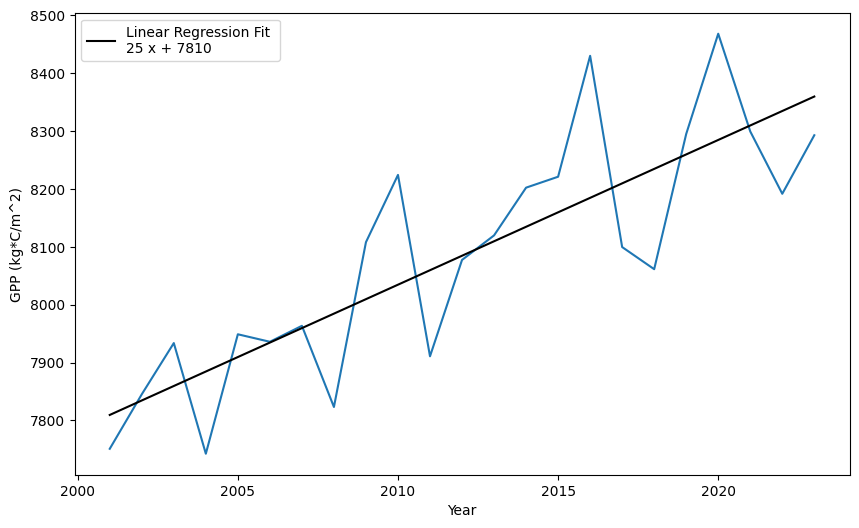

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_df["Year"], data_df["Gpp"])
# plt.ylim(24200, 26500)

# Calculate and add linear regression fitting line
x = np.arange(len(data_df))
coefficients = np.polyfit(x, data_df["Gpp"], 1)
poly_fit = np.poly1d(coefficients)
plt.plot(data_df["Year"], poly_fit(x), color='black', label='Linear Regression Fit'+str(poly_fit))


# Add labels and legend
plt.xlabel('Year')
plt.ylabel('GPP (kg*C/m^2)')
plt.legend()
plt.show()

### D. Time-Series NPP


##### D.1 Image Statistics for Npp ImageCollection

In [ ]:
# #Visualize NPP
# Map = geemap.Map(center = center, zoom = zoom, height=height, width=width)
# vis_ParaNPP = {'min':0, 'max':19000, 'palette':['FF0000', 'E7EC77', '4EC96A']}  # palette red:'FF0000', yellow:'E7EC77', green:'4EC96A'
# Map.addLayer(gpp.first().clip(aoi), vis_ParaNPP, name="NPP")
# Map

In [ ]:
# Create FeatureCollection of image statistics with additional "geometry" and "millis" field
# pass input FeatureCollection  "npp"
stat_fc = ee.FeatureCollection(npp.map(reduce_index))

# Display output
display(stat_fc)

In [ ]:
data_dict = fc_to_dict(stat_fc).getInfo() # dictionary
data_df = pd.DataFrame(data_dict)         # data_frame
display(data_df.head())                   # display table

,Npp,millis,system:index
0,1245.517352,978307200000,2001_01_01
1,1323.668115,1009843200000,2002_01_01
2,1390.589496,1041379200000,2003_01_01
3,1265.413466,1072915200000,2004_01_01
4,1412.804925,1104537600000,2005_01_01


In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

data_df = add_date_info(data_df)
data_df = data_df.drop(columns=['millis', 'system:index'])
display(data_df.head())

,Npp,Timestamp,Year,Month,Day,DOY
0,1245.517352,2001-01-01,2001,1,1,1
1,1323.668115,2002-01-01,2002,1,1,1
2,1390.589496,2003-01-01,2003,1,1,1
3,1265.413466,2004-01-01,2004,1,1,1
4,1412.804925,2005-01-01,2005,1,1,1


##### D.3 Visualize

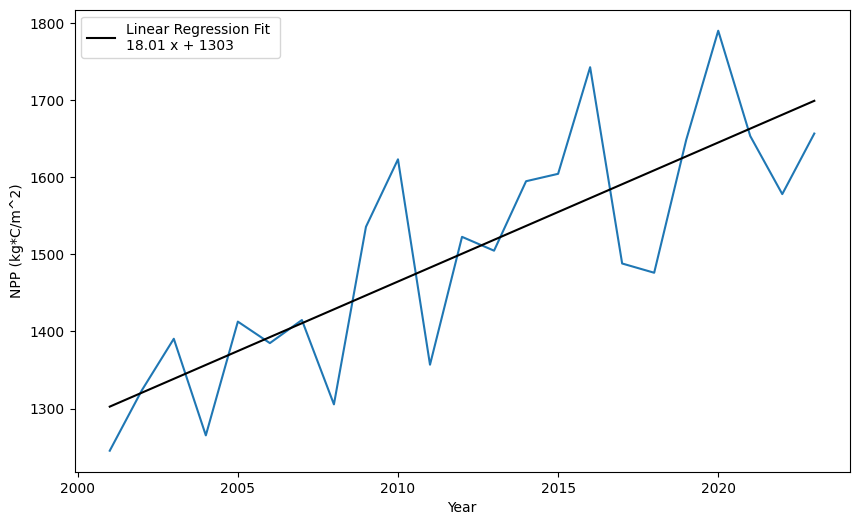

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_df["Year"], data_df["Npp"])
# plt.ylim(24200, 26500)

# Calculate and add linear regression fitting line
x = np.arange(len(data_df))
coefficients = np.polyfit(x, data_df["Npp"], 1)
poly_fit = np.poly1d(coefficients)
plt.plot(data_df["Year"], poly_fit(x), color='black', label='Linear Regression Fit'+str(poly_fit))


# Add labels and legend
plt.xlabel('Year')
plt.ylabel('NPP (kg*C/m^2)')
plt.legend()
plt.show()

### E. NDVI trend analysis

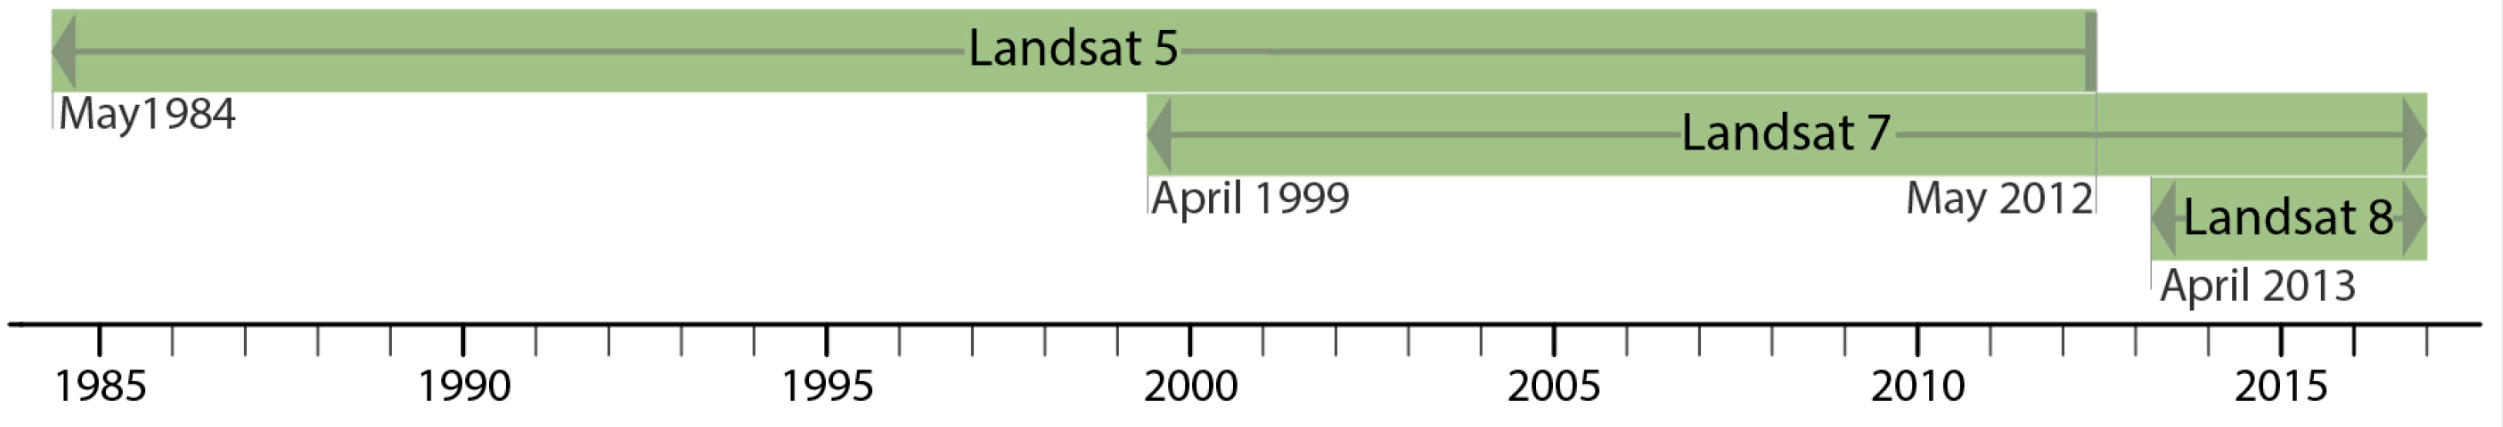

##### E.1 Landsat data loading, and preprocessing

In [ ]:
#  Cloud masking algorithms for Landsat 4, 5, 7 surface reflectance
def maskL457sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(ee.Number.parse('11111', 2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)    # The QA_RADSAT band indicates which sensor band(s) are saturated.

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B6').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)

################################################################################

# Define the time range
start_year = 1985
end_year = 2010

# Load the Landsat-5 image collection
landsat5Col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')

################################################################################

# Define a function to create semi-annual composites
def CreateSemiAnnualComposite(year, semi_annual_period):
    start_month = 1 if semi_annual_period == 1 else 7
    end_month = 6 if semi_annual_period == 1 else 12
    start_date = datetime(year, start_month, 1)
    end_date = datetime(year, end_month, 30)  # Using 30th as the end day for simplicity

    # Filter Landsat 5 Surface Reflectance collection for each semi-annual period
    collection = (landsat5Col
                  .filterBounds(aoi)
                  .filterDate(start_date, end_date)
                  .map(algorithm=maskL457sr))

    # Create the semi-annual composite by taking the median
    composite = collection.median()

    return composite.set('year', year).set('semi_annual_period', semi_annual_period)


# Create semi-annual composites for each year and semi-annual period
SemiAnnualCol = ee.ImageCollection.fromImages([
    CreateSemiAnnualComposite(year, period)
    for year in range(start_year, end_year + 1)
    for period in [1, 2]  # Two semi-annual periods per year
])

# Display the filtered image collection
display(SemiAnnualCol)

##### E.2 Note that some images in the above collections do not have any data (bands) for analysis. Remove those datasets

In [ ]:
# Define a function to filter out images with zero bands
def filter_non_zero_bands(image):
    band_count = image.bandNames().size()
    return image.set('band_count', band_count)

# Map the filter function over the image collection
SemiAnnualCol_with_band_count = SemiAnnualCol.map(filter_non_zero_bands)

# Filter the image collection to remove images with zero bands
SemiAnnualCol_filtered = SemiAnnualCol_with_band_count.filterMetadata('band_count', 'greater_than', 0)

# Display the filtered image collection
display(SemiAnnualCol_filtered)

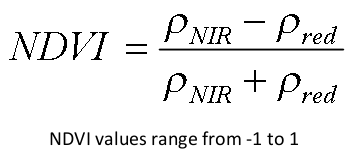

In [ ]:
# Define a function to calculate NDVI
def defNDVI(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return image.addBands(ndvi)

# Calculate NDVI for each image in collection
ndviCol = SemiAnnualCol_filtered.map(defNDVI)

# Display the image collection info
display(ndviCol)

# Display the first image in NDVI image collection
display(ndviCol.first())

##### E.3 Since there are many bands in each image of the collection, we'll are only interested in NDVI band, so selecting only NDVI band


In [ ]:
def select_band(image):
    return image.select(['NDVI'])

# Map the function over the image collection to select only the desired band
ndviCol_Filt = ndviCol.map(select_band)

display(ndviCol_Filt)

In [ ]:
## read properties
# display(ndviCol_Filt.first().propertyNames())
# display(ndviCol_Filt.first().get('year'))

##### E.4 Conversion: Reduce and Structure the data to pandas dataframe

In [ ]:
# Function definition for image reducer
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.select('NDVI').updateMask(img.gte(0.1)).reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)
    return ee.Feature(geometry, stat).set({'year': img.get('year'), }).set({'semi_annual_period': img.get('semi_annual_period'), })
  return reduce_region_function

# Define function
reduce_index = create_reduce_region_function(
     geometry=aoi,
     reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:4326')


# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
# Create FeatureCollection of image statistics with additional "geometry" and "millis" field
stat_fc = ee.FeatureCollection(ndviCol_Filt.map(reduce_index))

# Display ndvi feature collection with added properties like: ndvi value, semi_annual_period, year etc.
display(stat_fc)

In [ ]:
# display dataframe (initial)
data_dict = fc_to_dict(stat_fc).getInfo() # dictionary
data_df = pd.DataFrame(data_dict)         # data_frame
display(data_df.head())                   # display table

,NDVI,semi_annual_period,system:index,year
0,0.148515,2,3,1986
1,0.131637,2,5,1987
2,0.167335,1,6,1988
3,0.154348,2,7,1988
4,0.154612,1,8,1989


In [ ]:
# # Separate data into different DataFrames based on 'semi_annual_period'
# data_df = data_df[data_df['semi_annual_period'] == 1]
# # data_df = data_df[data_df['semi_annual_period'] == 2]

# data_df.head()

In [ ]:
# Function to add date 'Timestamp' to DataFrame.
def add_date_info(df):
  df['Timestamp'] = df['year'].astype(str) + '/' + df['semi_annual_period'].astype(str)
  return df

data_df = add_date_info(data_df)
data_df = data_df.drop(columns=['semi_annual_period', 'system:index', 'year'])  # remove unwanted columns
display(data_df.head())

,NDVI,Timestamp
0,0.148515,1986/2
1,0.131637,1987/2
2,0.167335,1988/1
3,0.154348,1988/2
4,0.154612,1989/1


##### E.5 Visualize the time series trend

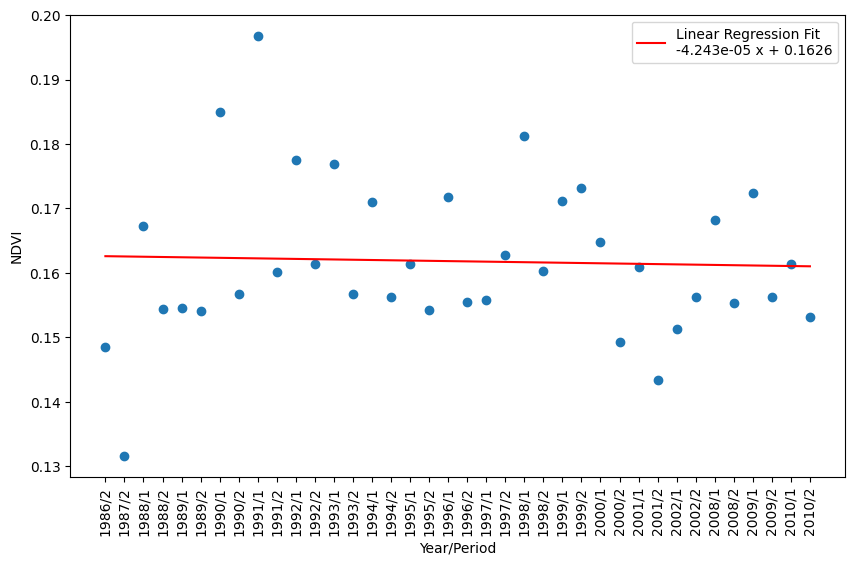

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(data_df["Timestamp"], data_df["NDVI"])
# plt.ylim(26200, 27500)
plt.xticks(rotation='vertical')

# Calculate linear regression
x = np.arange(len(data_df))
coefficients = np.polyfit(x, data_df["NDVI"], 1)
poly_fit = np.poly1d(coefficients)
plt.plot(data_df["Timestamp"], poly_fit(x), color='red', label='Linear Regression Fit '+ str(poly_fit))


plt.xlabel('Year/Period')
plt.ylabel('NDVI')
plt.legend()
plt.show()

Note: Some data may be missing resulting in gaps between some years. This could depend on filters(date, cloud filter), simply masking of dataset, or missing imageries for the period.

#### Plot Residuals (optional)

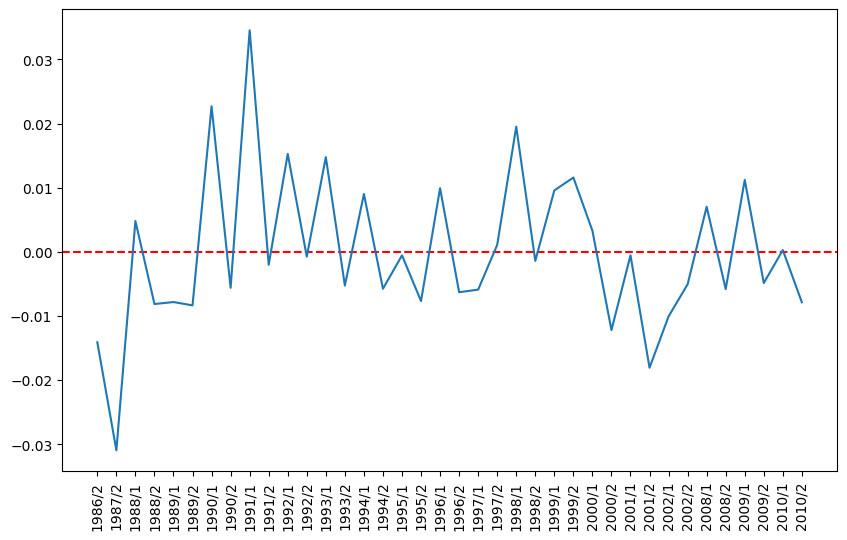

In [ ]:
# Calculate the residuals (variation from the linear regression line)
slope, intercept = coefficients
regression_line = slope * np.array(range(len(data_df['Timestamp']))) + intercept
residuals = data_df["NDVI"] - regression_line

plt.figure(figsize=(10, 6))
plt.xticks(rotation='vertical')
# Plot horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')

plt.plot(np.array(data_df["Timestamp"]), residuals)
